In [ ]:
import pandas as pd 
import numpy as np
from keras.preprocessing.image import * 
from keras.preprocessing import image 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import random
import os 


In [ ]:

path = "./dog_or_cat/"

# 데이터 형상 관련 상수 정의 
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNEL=3


In [ ]:

# 학습 데이터 준비 
filenames = os.listdir(path+"train")

categories=[]
for filename in filenames:
    category=filename.split(".")[0]
    if category =="dog":
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame(
    {"filename":filenames,
    "category":categories}
)        
df

In [ ]:
df['category'].value_counts().plot.bar()

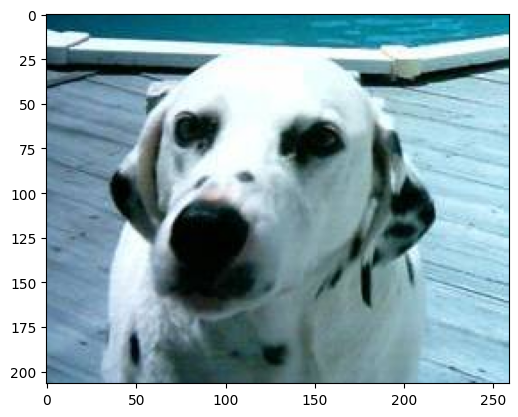

In [261]:
# sample = random.choice(filenames)
# image = Image.open(os.path+"train\\"+sample)
# plt.imshow(image)

sample = random.choice(filenames)
image = Image.open(path + "train/" + category+ '.' + sample)
plt.imshow(image)

In [ ]:
from keras.models import Sequential
from keras.layers import * 

In [ ]:
# 레이어 1
model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH , IMAGE_CHANNEL)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 레이어 2 
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 레이어3
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
          
# Fully Connected 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2,activation="softmax"))

In [ ]:
# 모델 실행 옵션 
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
model.summary()

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_accuracy", 
                        patience = 2, 
                        factor = 0.5, 
                        min_lr=0.0001,
                        verbose=1)
                        
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
df['category']=df['category'].replace({0:'cat',1:"dog"})

In [ ]:
train_df, validate_df = train_test_split(df , test_size=0.2, random_state= 42)

train_df=train_df.reset_index(drop=True)
validate_df=validate_df.reset_index(drop=True)


train_df['category'].value_counts()

In [ ]:
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

# 트레이닝 데이터의 제너레이터 설정 
train_datagen=ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1, 
        height_shift_range=0.1)
        
train_generator=train_datagen.flow_from_dataframe(
    train_df, 
    path+"train",
    x_col = "filename", 
    y_col = "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size )
    
validate_datagen=ImageDataGenerator(rescale=1./255)
# 검증이미지니까, 사진 그대로 쓰겠다. 

validation_generator=validate_datagen.flow_from_dataframe(
    validate_df,
    path+"train",
    x_col= "filename",
    y_col= "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size )

In [ ]:
epochs = 3 

history = model.fit_generator(
    train_generator, 
    epochs = epochs, 
    steps_per_epoch = total_train//batch_size ,
    validation_data=  validation_generator,
    validation_steps = total_validate//batch_size,
    callbacks = callbacks,
)


In [ ]:
# 테스트 데이터 준비 
filenames = os.listdir(path+"test1")

test_df=pd.DataFrame( {"filename":filenames} )      

nbsamples=test_df.shape[0]

In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255)
# 테스트 이미지니까, 사진 그대로 씀
test_generator=test_datagen.flow_from_dataframe(
    test_df,
    path+"test1",
    x_col= "filename",
    y_col= None,
    target_size = IMAGE_SIZE,
    class_mode = None,
    batch_size = batch_size,
    shuffle = False)

In [ ]:
# 3. 예측 
predict=model.predict_generator(test_generator, 
                                steps=nbsamples/batch_size, 
                                callbacks=callbacks)
                                
test_df['category']=np.argmax(predict, axis=1)

In [272]:
test_df['category']=test_df['category'].replace({0:'cat',1:"dog"})
ex_df=test_df.sample(n=10).reset_index(drop=True)
ex_df

,filename,category
0,5479.jpg,dog
1,10462.jpg,dog
2,3536.jpg,dog
3,540.jpg,cat
4,11918.jpg,dog
5,12493.jpg,dog
6,3381.jpg,dog
7,6843.jpg,cat
8,7166.jpg,dog
9,4434.jpg,dog


In [ ]:
ex_generator = test_datagen.flow_from_dataframe(
                    ex_df,
                    path+"test1",
                    x_col = "filename",
                    y_col = None,
                    target_size = IMAGE_SIZE,
                    class_mode = None)

In [ ]:
test_sample=list(ex_df.filename)

sample = ""
for test in test_sample:
    sample += test

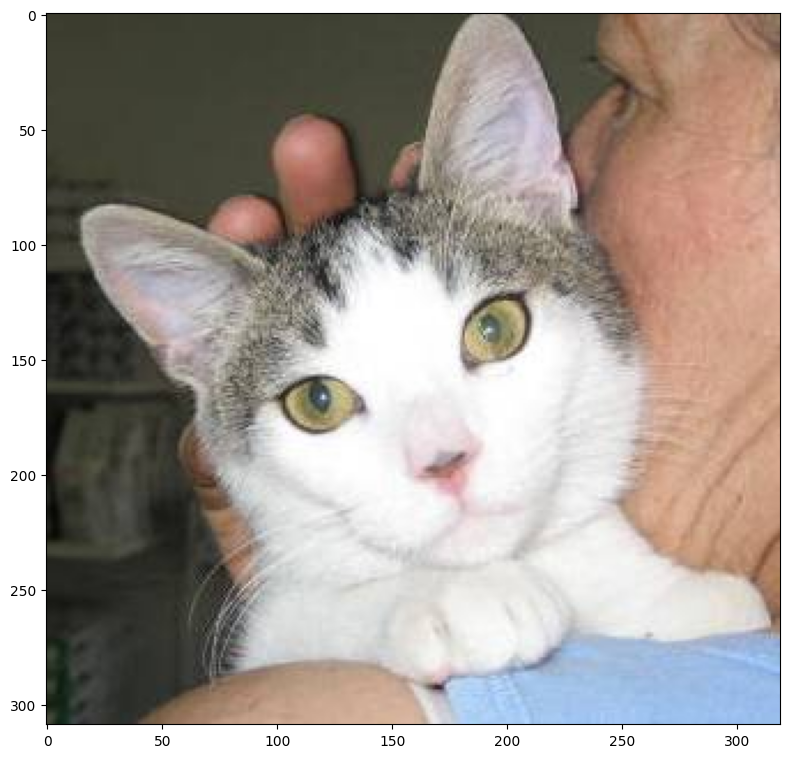

      filename category
8389  6299.jpg      dog


In [274]:
sample2 = random.choice(filenames)
image2 = Image.open(path+"test1\\"+sample2)
plt.figure(figsize=(8,8))
plt.imshow(image2)
plt.tight_layout()
plt.show()

specific_file_df = test_df[test_df['filename'] == sample2]

print(specific_file_df)

In [ ]:
correct = 0
total = len(predictions_sgd)

for i in range(len(predictions_sgd)):
    if round(predictions_sgd[i][0]) == y_test[i]:
        correct += 1

accuracy = (correct / total) * 100
print(f"정확도: {accuracy:.2f}%")